# Step 4: visualization

In [14]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import h5py
from tqdm import tqdm
from tqdm import trange
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import patches
import plotly.graph_objs as go
from ipywidgets import interactive
from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [15]:
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.style.use('fast')
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'

## Load data 

In [16]:
folder = '_output'

In [17]:
info = utils.load_pickle(join(folder, 'info.pkl'))
info

{'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'variables': {'y1': {'pvname': 'ITSF_Diag:Slit_HZ34a',
   'center': 6.5,
   'distance': 14.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x2': {'pvname': 'ITSF_Diag:Slit_VT34b',
   'center': 15.0,
   'distance': 24.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x1': {'pvname': 'ITSF_Diag:Slit_VT34a',
   'center': 21.0,
   'distance': 17.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0}},
 'M': array([[1. , 0. , 0. ],
        [0. , 1. , 1.9],
        [0. , 0. , 1. ]]),
 'ndim': 3,
 'cam': 'cam34',
 'cam_zoom': 0.5,
 'cam_pix2mm_y': 0.298019801980198,
 'cam_pix2mm_x': 0.29844961240310075,
 'cam_shape': (512, 612),
 'image_crop_edges': {'x1': 135, 'x2': 520, 'y1': 134, 'y2': 435},
 'image_offset': 28,
 'image_thresh': 88.2,
 'image_downscale': 3,
 'image_shape': (101, 129),
 'rawgrid_shape': (33, 33, 32, 101, 129),
 'im_dtype': dtype('float64'),
 'int_shape': (36, 66, 35, 101, 129)}

In [18]:
shape = info['int_shape']

In [19]:
coords = utils.load_stacked_arrays(join(folder, 'coords.npz'))
for c in coords:
    print(c.shape)

(36,)
(66,)
(35,)
(101,)
(129,)


In [20]:
f = np.memmap(join(folder, 'f.mmp'), shape=shape, dtype='float', mode='r')

In [21]:
f_min = np.min(f)
if f_min < 0.0:
    print(f'min(f) = {f_min}')
    print('Clipping to zero.')
    f = np.clip(f, 0.0, None)

min(f) = -2.6700716404376893e-14
Clipping to zero.


In [22]:
# f = f[..., ::-1]

## Static 

In [30]:
dims = ["x", "xp", "y", "yp", "w"]
units = ["mm", "mrad", "mm", "mrad", "MeV"]
dims_units = [f'{d} [{u}]' for d, u in zip(dims, units)]
dim_to_int = {dim: i for i, dim in enumerate(dims)}
prof_kws = dict(lw=0.5, alpha=0.7, color='white', scale=0.12)

### Projections

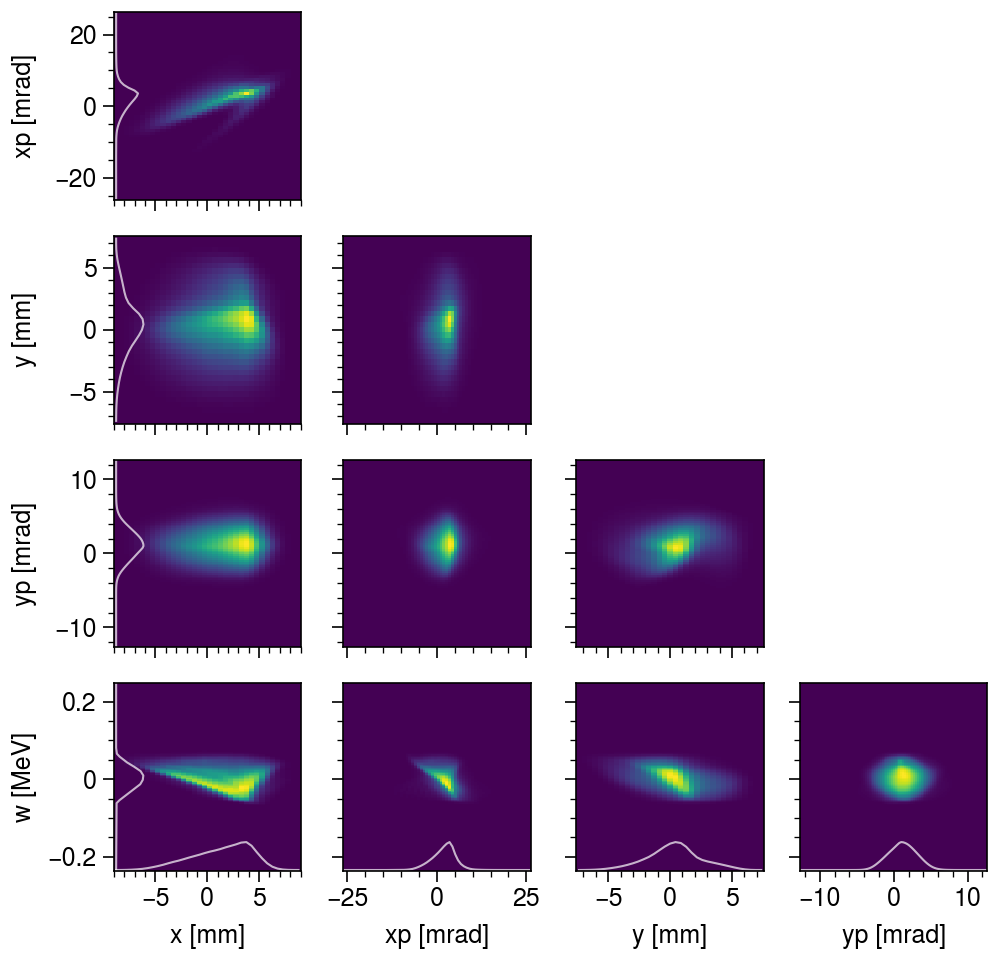

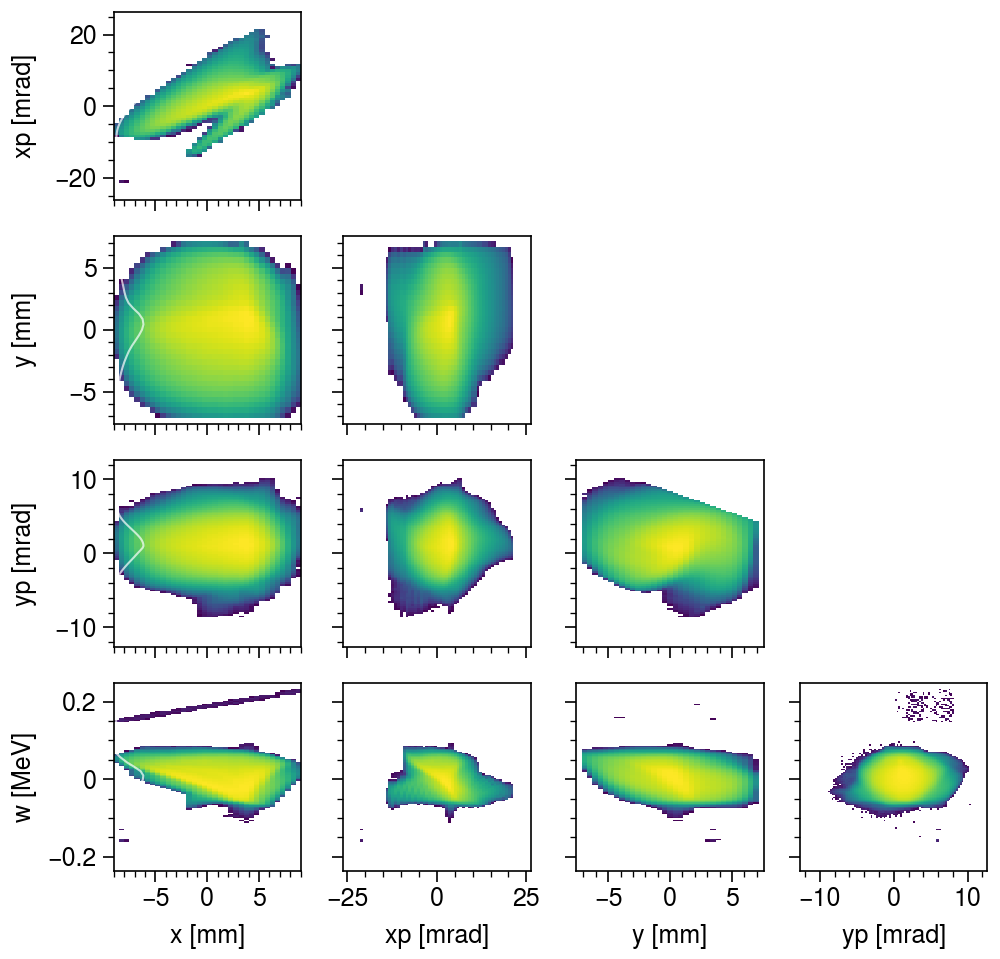

In [25]:
for norm in [None, 'log']:
    axes = mplt.corner(
        f,
        coords=coords,
        diag_kind='None',  # {'line', 'None'}
        prof='edges',  # {True, False, 'edges'}
        prof_kws=prof_kws,
        labels=dims_units,
        norm=norm,
        frac_thresh=1e-6,
    )
    plt.savefig(f'_output/int_corner_norm{norm}.png')
    plt.show()

### Slices

In [26]:
ind = np.unravel_index(np.argmax(f), f.shape)
ind = tuple([i for i in ind])
print(ind)

(22, 38, 20, 54, 53)


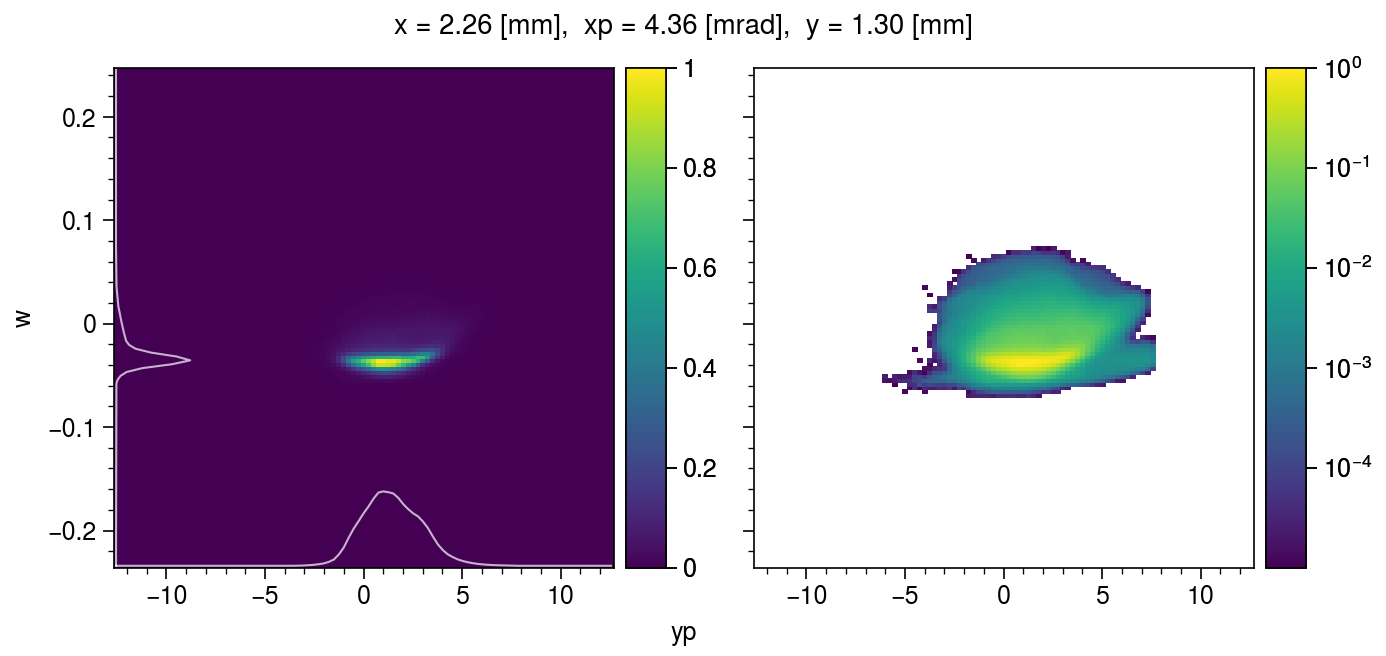

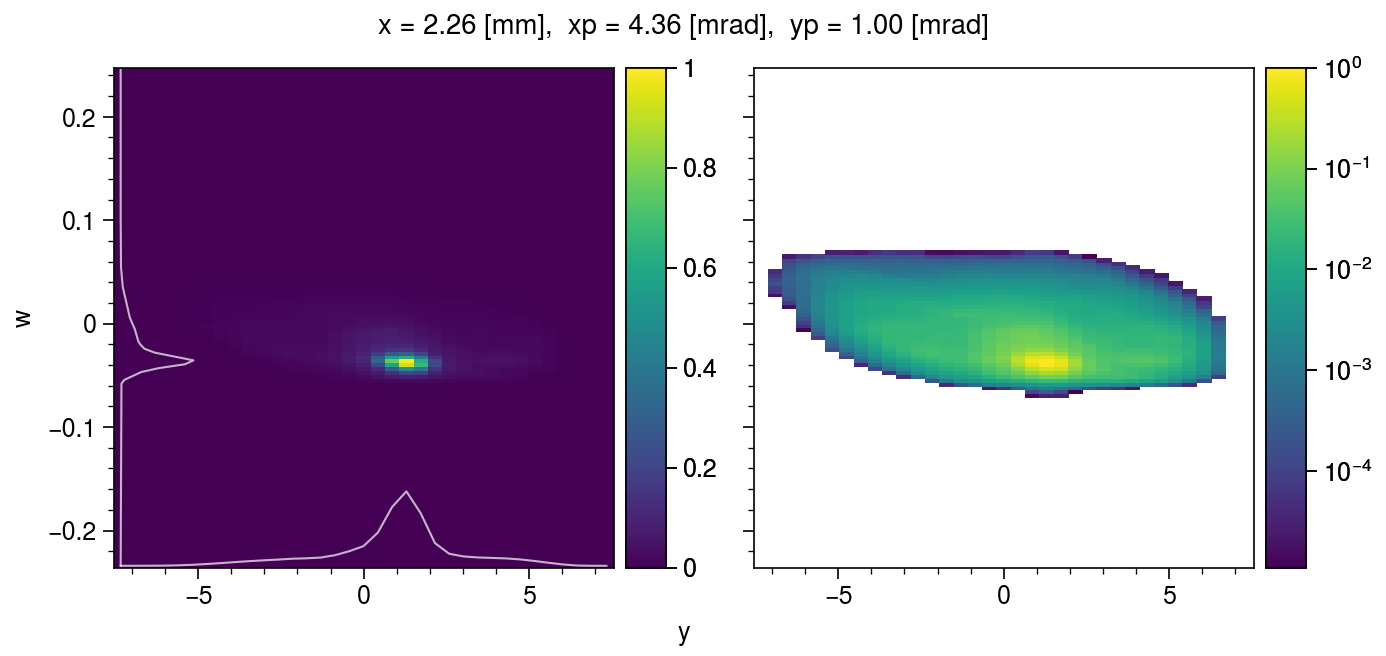

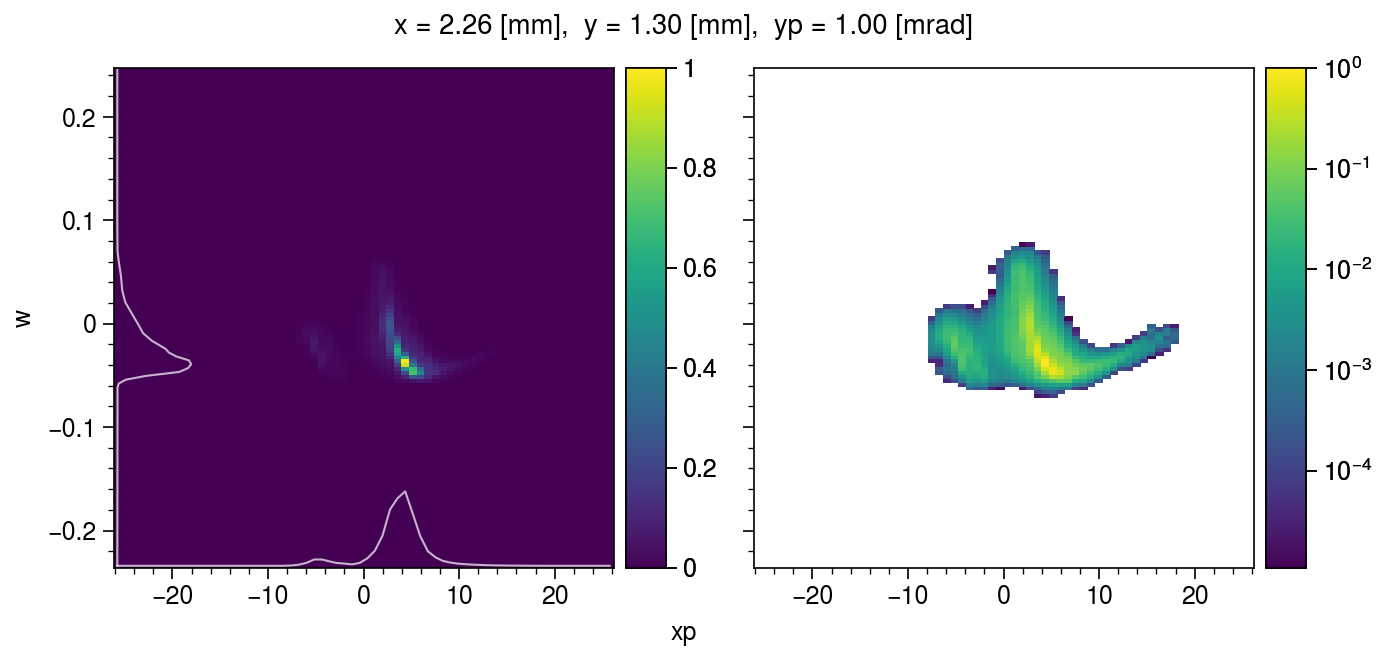

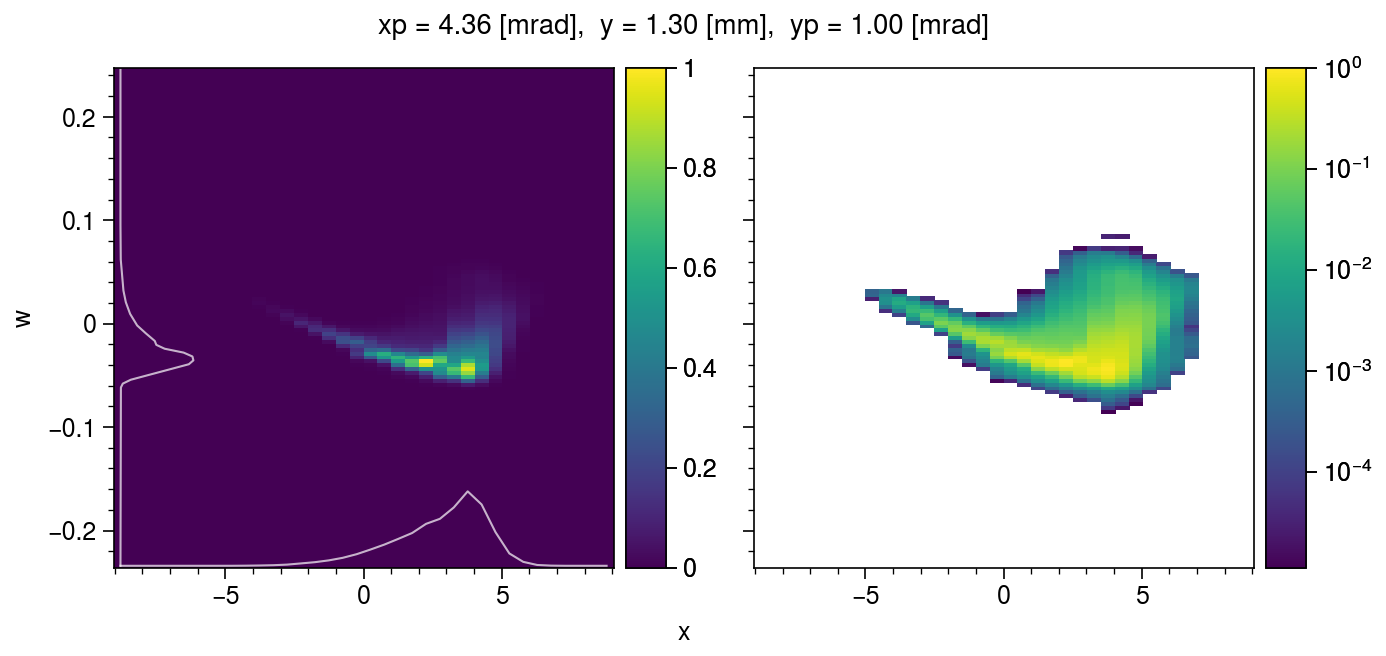

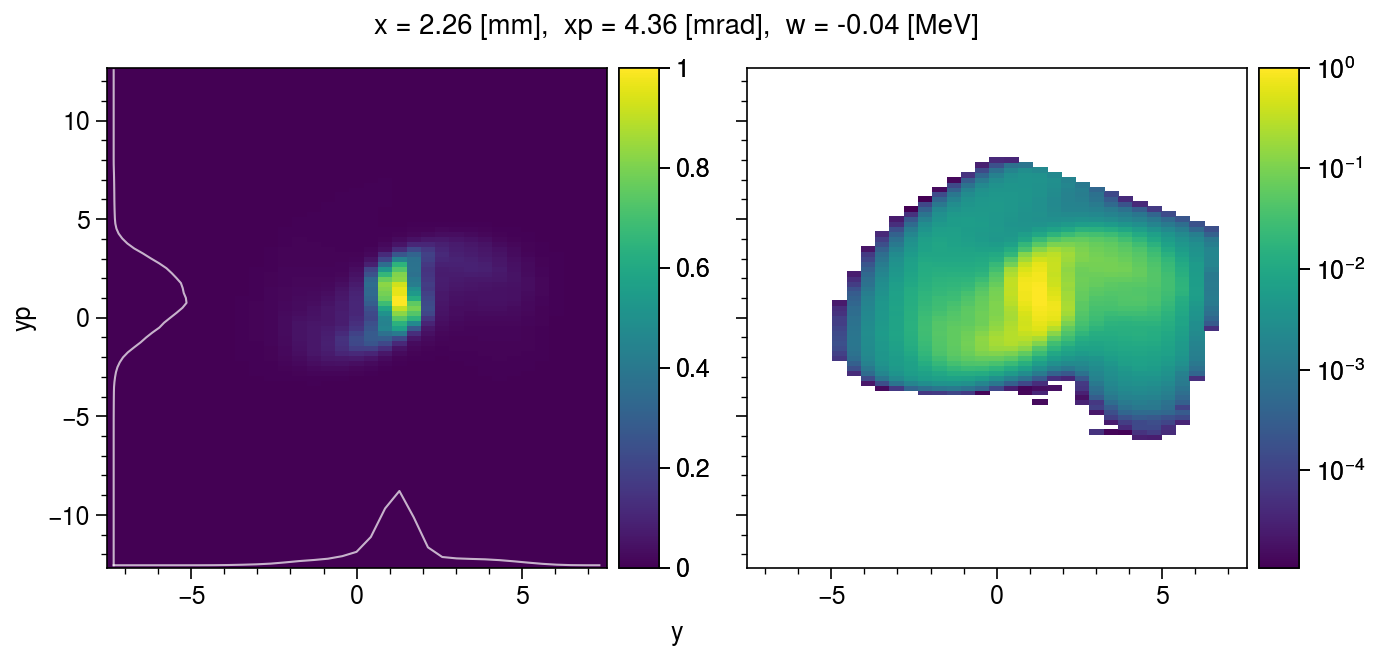

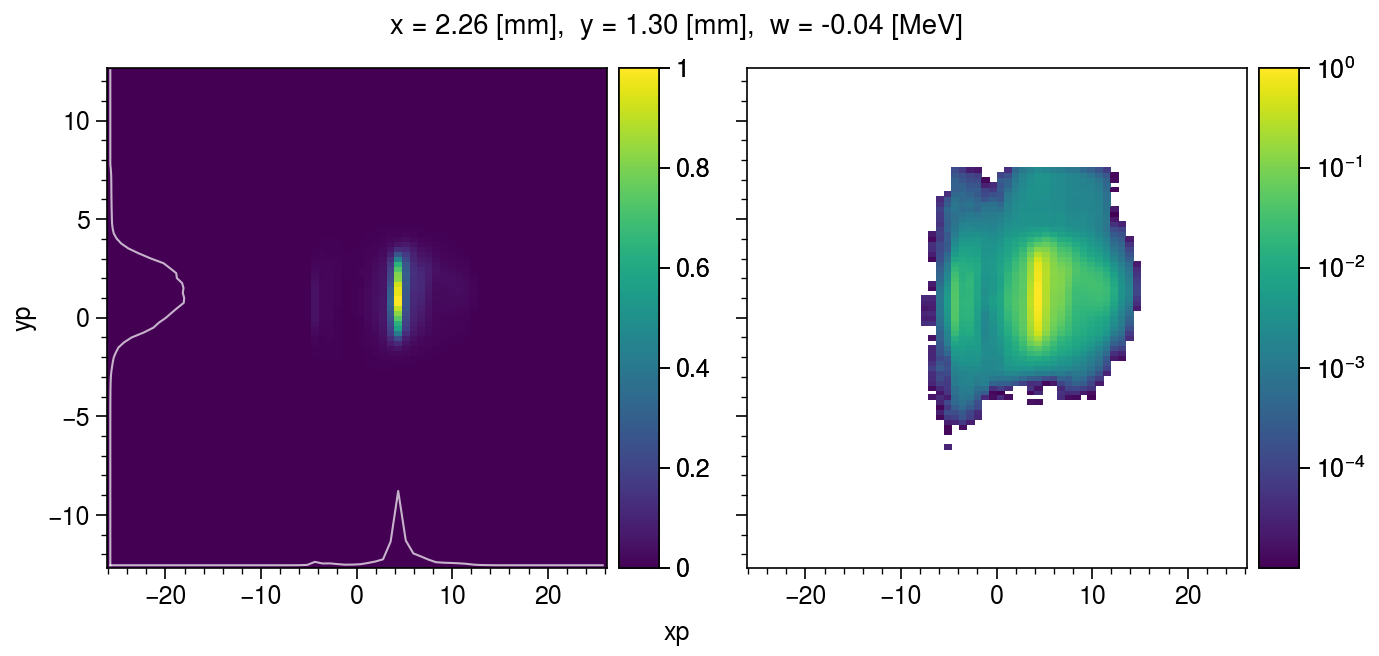

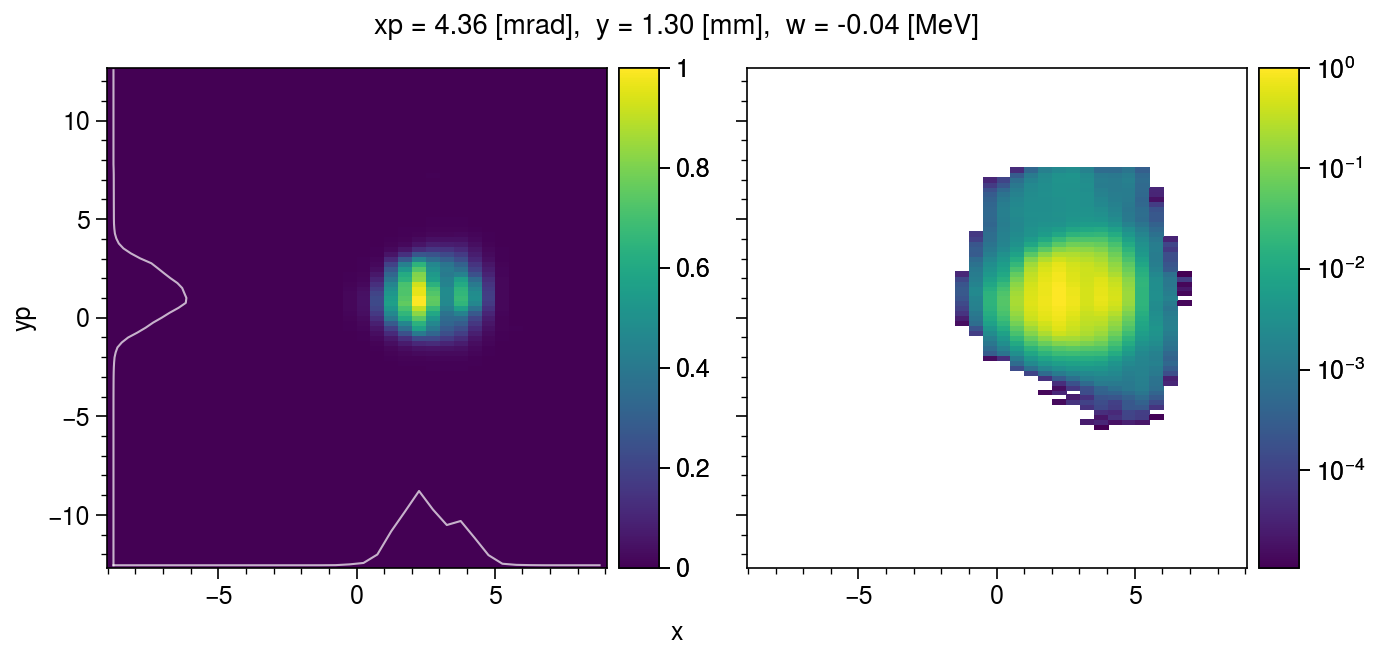

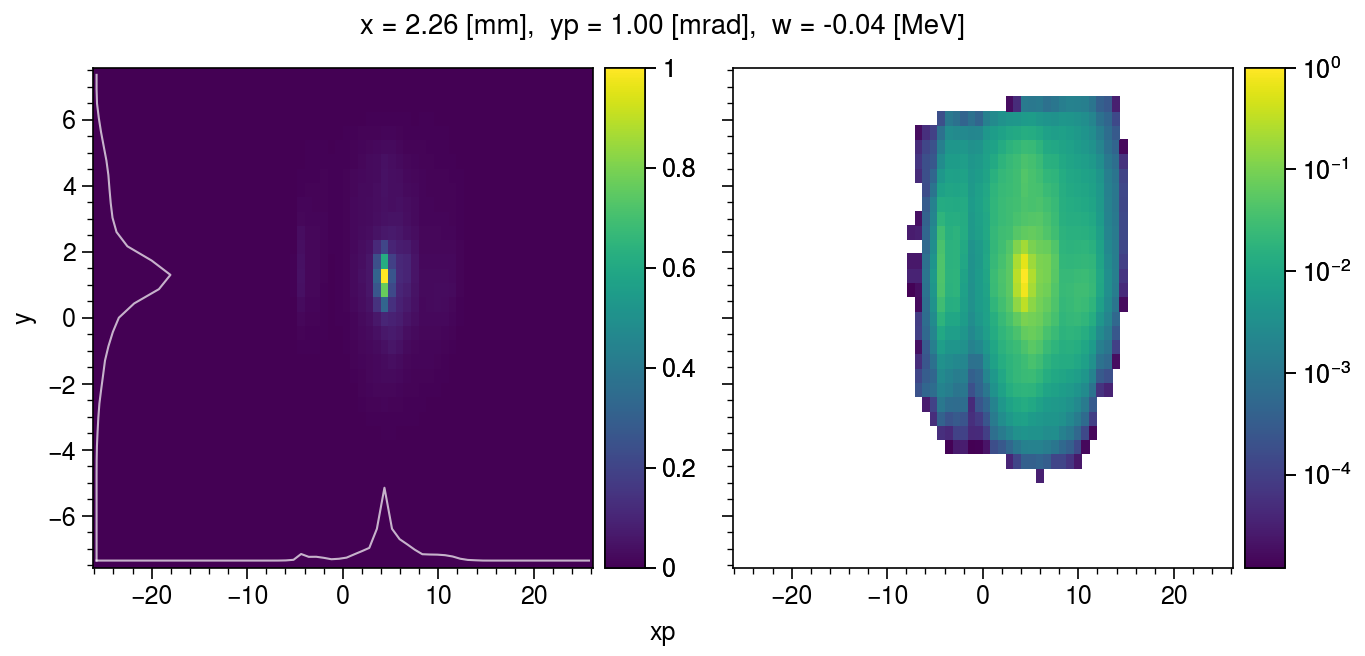

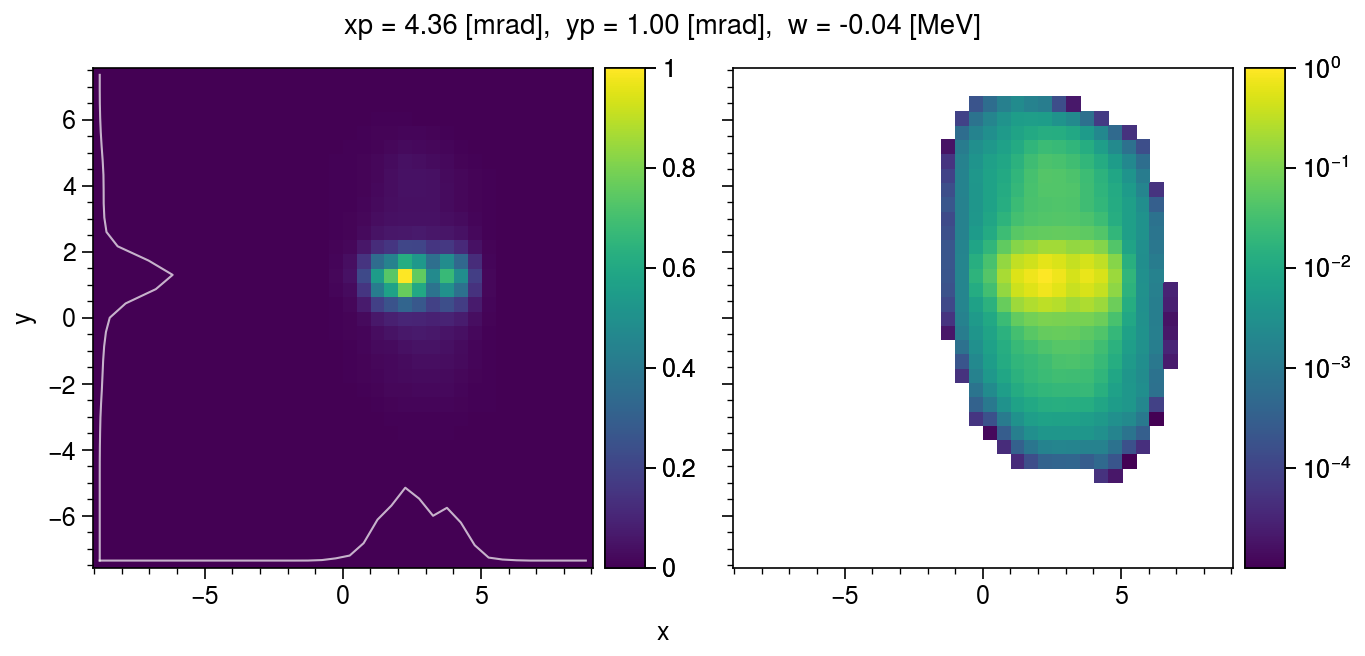

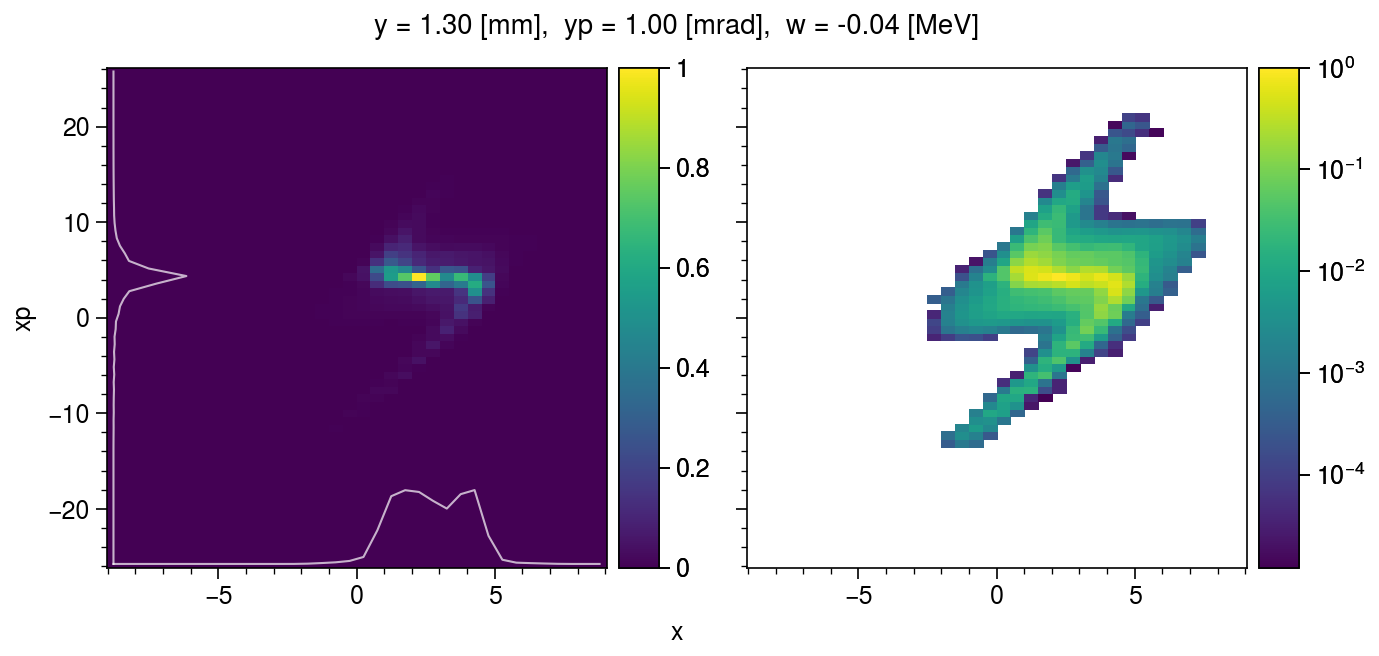

In [27]:
frac_thresh = 1e-5
prof = True

axes_slice = [(k, j, i) for i in range(f.ndim) for j in range(i) for k in range(j)]
axes_view = [tuple([i for i in range(f.ndim) if i not in axis])
             for axis in axes_slice]
for axis, axis_view in zip(axes_slice, axes_view):
    idx = utils.make_slice(5, axis, [ind[i] for i in axis])
    f_slice = f[idx]
    f_slice = f_slice / np.max(f_slice)
    
    dim1, dim2 = [dims[i] for i in axis_view]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(f_slice, x=coords[axis_view[0]], y=coords[axis_view[1]],
                        ax=ax,
                        profx=prof, profy=prof, prof_kws=prof_kws,
                        frac_thresh=frac_thresh, norm=norm, colorbar=True)
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    string = '_output/int_slice_'
    for i in axis:
        string += f'{dims[i]}-{ind[i]}'
    _dims = [dims[i] for i in axis]
    _units = [units[i] for i in axis]
    _vals = [coords[i][ind[i]] for i in axis]
    plot_axes.format(suptitle=f'{_dims[0]} = {_vals[0]:.2f} [{_units[0]}],  {_dims[1]} = {_vals[1]:.2f} [{_units[1]}],  {_dims[2]} = {_vals[2]:.2f} [{_units[2]}]')
    plot_axes.format(suptitle_kw=dict(fontweight='normal'))
    plt.savefig(string + '.png')
    plt.show()

## Interactive plots

### 2D projection of int slice 

Slicing along each dimension is controlled by the checkboxes and sliders. The sliced distribution is projected onto dimensions `dim1` and `dim2`. 

In [64]:
cut = 20
_f = f[..., cut:-cut]
_coords = [c.copy() for c in coords]
_coords[-1] = _coords[-1][cut:-cut]

In [65]:
mplt.interactive_proj2d(_f / np.max(_f), coords=_coords, default_ind=(2, 3),
                        slider_type='int', dims=dims, units=units)

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

In [68]:
i, j = 0, 1
f3d = utils.project(_f, axis=(i, j, 4))
f3d = f3d / np.max(f3d)
vmin = np.min(f3d)
vmax = np.max(f3d)

def update(k):
    fig, ax = pplt.subplots()
    H = f3d[:, :, k].T
    ax.pcolormesh(_coords[i], _coords[j], H,
                  vmin=vmin, vmax=vmax, 
                  # norm='log', 
                  colorbar=True)
    ax.format(xlabel=dims_units[i], ylabel=dims_units[j])
    
interactive(update, k=(0, f3d.shape[-1]))

interactive(children=(IntSlider(value=44, description='k', max=89), Output()), _dom_classes=('widget-interact'…

### 2D projection of range slice

Unfortunately, ipywidgets does not currently allow you to drag the center of the slider. 

In [66]:
mplt.interactive_proj2d(_f / np.max(_f), coords=_coords, default_ind=(2, 3),
                        slider_type='range', dims=dims, units=units)

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

## Emittance vs. energy

Compute the 5$\times$5 covariance matrix (this will take a few minutes).

In [ ]:
Sigma, means = utils.dist_cov(f, coords)

In [ ]:
from sympy import Matrix
Matrix(np.round(Sigma, 3))

Compute the 5$\times$5 correlation matrix from the covariance matrix.

In [ ]:
Corr = utils.cov2corr(Sigma)
Matrix(np.round(Corr, 3))

In [ ]:
i, j = (0, 4)
angle, cx, cy = utils.rms_ellipse_dims(Sigma[i, i], Sigma[j, j], Sigma[i, j])
center = (means[i], means[j])
width = 4.0 * cx
height = 4.0 * cy

fig, ax = pplt.subplots()
ax.pcolormesh(coords[i], coords[j], utils.project(f, (i, j)).T)
ax.add_patch(
    patches.Ellipse(
        center, width=width, height=height, angle=-np.degrees(angle),
        ec='white', fill=False))
ax.format(xlabel=dims_units[i], ylabel=dims_units[j])
plt.show()

In [ ]:
axes = mplt.corner(
    f,
    coords=coords,
    prof=False,
    prof_kws=dict(alpha=0.5, lw=0.9),
    labels=dims_units,
    frac_thresh=1e-6,
)
for i in range(5):
    for j in range(i):
        ax = axes[i, j]
        angle, cx, cy = utils.rms_ellipse_dims(Sigma[j, j], Sigma[i, i], Sigma[j, i])
        center = (means[j], means[i])
        width = 4.0 * cx
        height = 4.0 * cy
        angle = -np.degrees(angle)
        ax.add_patch(patches.Ellipse(center, width, height, angle=angle,
                                     ec='white', fill=False, lw=0.75, alpha=0.9))
plt.savefig('_output/int_corner_cov.png')
plt.show()

In [ ]:
import tools.analysis as ba
alpha_x, alpha_y, beta_x, beta_y = ba.twiss2D(Sigma)
eps_x, eps_y, eps_1, eps_2 = ba.emittances(Sigma)
print(f'alpha_x = {alpha_x}')
print(f'alpha_y = {alpha_y}')
print(f'beta_x = {beta_x}')
print(f'beta_y = {beta_y}')
print(f'epsx = {eps_x}')
print(f'epsy = {eps_y}')
print(f'eps1 = {eps_1}')
print(f'eps2 = {eps_2}')

Try computing emittances for each energy slice.

In [ ]:
i, j = (0, 4)
f3d = utils.project(f, (i, j, 4))

In [ ]:
_Sigmas = []  # transverse covariance matrices
_means = []  # transverse mean
for k in trange(shape[4]):
    _Sigma, _mean = utils.dist_cov(f[:, :, :, :, k], coords[:4])
    _Sigmas.append(_Sigma)
    _means.append(_mean)

In [ ]:
_emittances = []
for _Sigma in _Sigmas:
    _emittances.append(ba.emittances(_Sigma))
_emittances = np.array(_emittances)
eps_x, eps_y, eps_1, eps_2 = ba.emittances(Sigma)

In [ ]:
colors = pplt.Cycle('colorblind').by_key()['color']
labels = [r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$']

fig, ax = pplt.subplots(figsize=(4.5, 2.5))
for i in range(2):
    ax.plot(coords[4], _emittances[:, i], label=labels[i], marker='.', ms=3)
for i in range(2):
    ax.axhline([eps_x, eps_y, eps_1, eps_2][i], color=colors[i], label=labels[i]+' (full)', 
               alpha=0.3, ls='-')
ax.format(ylabel='[mm mrad]', xlabel='w [MeV]', title='Energy slice emittances')
ax.legend(ncols=1, loc='r')
plt.savefig('_output/int_slice_emittances.png')

In [ ]:
n = 12
ncols = 6

for (i, j) in [(0, 1), (2, 3)]:
    f3d = utils.project(f, (i, j, 4))
    step = f3d.shape[2] // n
    nrows = int(np.ceil(n / ncols))
    w_coords = coords[4]
    ks = np.arange(0, f3d.shape[2], step)

    fig, axes = pplt.subplots(ncols=ncols, nrows=nrows, figwidth=9.0)
    for ax, k in zip(axes, ks):
        ax.pcolormesh(coords[i], coords[j], f3d[:, :, k].T)
        ax.annotate(f'w = {w_coords[k]:.2f} [MeV]', xy=(0.02, 0.98), verticalalignment='top',
                    xycoords='axes fraction', fontsize='small', color='white')
    axes.format(xlabel=dims_units[i], ylabel=dims_units[j])
    # plt.savefig(f'_output/int_slice_plots_{dims[i]}.png')
    plt.show()